In [41]:
""" Load some libs """
""" python 2 lib using networkx """
import matplotlib.pyplot as plt
import networkx as nx
import random
import math
import pandas as pd
import statsmodels.api as sm
import glob
import os
import numpy as np
from PIL import Image
import pickle
import time
#random.seed(100)
#tic = time.time()

In [42]:
""" some helpers """
def format_hr(row):
    if row['MW']<=400:
    	row_MW = '0-400'
    elif row['MW']<=500:
    	row_MW = '401-500'
    elif row['MW']<=700:
    	row_MW = '501-700'
    elif row['MW']<=900:
    	row_MW = '701-900'
    elif row['MW']>900:
    	row_MW = '901-10000'


    if not row['fuel_class'] in ['COAL','OIL','GAS']:
        return np.nan
    elif row['fuel_class']=='COAL':
    	#no fuel type or stype
    	if row['FUELTYPE']=='' or pd.isnull(row['FUELTYPE']):
    		row_ftype = 'BIT'
       	elif row['FUELTYPE'].split('/')[0].upper() == 'ANTH':
    		row_ftype = 'BIT'
    	elif row['FUELTYPE'].split('/')[0].upper() in ['BIT','SUB','LIG']:
    		row_ftype = row['FUELTYPE'].split('/')[0].upper()
        else:
    		row_ftype = 'BIT'

    	if row['STYPE']=='' or pd.isnull(row['STYPE']):
    		row_stype = 'SUBCR'
    	else:
    		row_stype = row['STYPE']
    	try:
    	    return row['fuel_class']+'+'+row_ftype.upper()+'+'+row_stype.upper()+'+'+str(row_MW)
    	except:
    		print row['fuel_class'], row_ftype, row_stype, row_MW
    		exit()
    else: #oil or gas:
    	if row['UTYPE'].split('/')[0].upper() not in ['ST','GT','IC','CC']:
    		row_utype = 'ST'
    	else:
    	    row_utype = row['UTYPE'].split('/')[0].upper()
    	try:
    	    return row['fuel_class']+'+'+row_utype
    	except:
    		print row['fuel_class'], row_utype
    		exit()

def get_hr(row):
    if row['YEAR']<1949:
    	return row[1949]
    elif row['YEAR']>2016:
    	return row[2016]
    else:
        return row[int(row['YEAR'])]

def fill_year(row, est, cols):
	test = pd.DataFrame(np.zeros((1,len(cols))),columns = cols)
	#print row
	for k,v in row.items():
		#print k,v
		if not pd.isnull(v):
			test[k+'_'+v] = 1
	#print test
	test = sm.add_constant(test, has_constant='add')
	#print est.predict(test)
	return est.predict(test)

	#print pd.get_dummies(row)
	#inp = pd.get_dummies(row.T).reindex(columns=cols, fill_value = 0)
	#inp = sm.add_constant(inp)
	#print inp.T
	#print est.predict(inp)
	#return est.predict(inp)
    
def clamp(x): 
    return max(0, min(x, 255))

In [43]:
""" Let's see what WEPPS we have """
folders = sorted(glob.glob('WEPP_FILES/*'))
print folders
folder = folders[0]
print folder


['WEPP_FILES/2004-Q4-DEC', 'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2014-q4-dec', 'WEPP_FILES/2015-Q1-MAR', 'WEPP_FILES/2015-Q2-JUN', 'WEPP_FILES/2015-Q4-DEC', 'WEPP_FILES/2015-q3-sep', 'WEPP_FILES/2016-Q1-APR', 'WEPP_FILES/2016-Q2-JUL', 'WEPP_FILES/2016-Q3-SEP', 'WEPP_FILES/2016-Q4-DEC', 'WEPP_FILES/2017-Q1-MAR', 'WEPP_FILES/2017-Q2-JUL', 'WEPP_FILES/2017-Q3-SEP', 'WEPP_FILES/2017-Q4-DEC']
WEPP_FILES/2004-Q4-DEC


In [44]:
""" get our wepp db """
def get_wepp(folder):
    files = glob.glob(os.path.join(folder,'*'))
    for file in files:
        directory, fname = os.path.split(file)
        ext = fname.split('.')[-1]
        fbase = fname.split('.')[0]
        print ext, fbase

        if fbase.upper() == 'ALLUNITS':
            if ext == 'csv':
                return pd.read_csv(file)
            elif ext == 'xls' or 'xlsx':
                return pd.read_excel(file)

In [45]:
""" fix all the wepp stuff, add all the columns """
def calculate_CCCE(wepp_df):
    # merge with ISO, country budgets and load factors 
    print '~~~~~~ GENERATING DF ~~~~~~~'
    print 'loading df...'
    df_iso = pd.read_csv('country_ISO_update.csv')
    fuel_class = 'fuel_classification_database.dta'
    df_fuel_class = pd.io.stata.read_stata(fuel_class)
    heat_rates_xls = 'Heat rates_v3.xls'
    df_heatrates = pd.read_excel(heat_rates_xls, sheet_name='CSV_output')
    df_load_factor = pd.io.stata.read_stata('load_factor_database.dta')

    print 'loaded dfs: '
    print 'merging dfs and filling missing years...'
    #df_fuel_load = pd.merge(df_fuel_class, df_load_factor, on='fuel_class')
    #print df_iso
    #print df_fuel_class
    #print df_heatrates
    #print df_load_factor
    #print list(wepp_df)
    #print wepp_df['FUEL']

    df_fuel_class.rename(columns = {'fuel': 'FUEL'}, inplace = True)
    
    #fix fuel classes
    wepp_df = wepp_df.merge(df_fuel_class, on='FUEL', how='left')
    df_wepp_em_fact = pd.read_csv('wepp_em_fact.csv')

    #merge emissions factors
    wepp_df = wepp_df.merge(df_wepp_em_fact, left_on='FUEL', right_on='fuel', how='left')

    #prepare lookup indexer
    wepp_df['FORMAT_HR'] = wepp_df.apply(lambda row: format_hr(row), axis=1)

    #standardise statuses
    wepp_df.loc[wepp_df.STATUS=='DEF', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DEL', 'STATUS'] = 'CON'
    wepp_df.loc[wepp_df.STATUS=='UNK', 'STATUS'] = 'PLN'
    wepp_df.loc[wepp_df.STATUS=='DAC', 'STATUS'] = 'STN'

    #print  list(df_iso)

    #add ISO
    wepp_df = wepp_df.merge(df_iso[['Caps','ISO','Region']], left_on='COUNTRY', right_on='Caps', how='left')

    #fill in missing years
    all_training = wepp_df[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']]
    all_training['fuel_class'] = all_training['fuel_class'].astype('category')
    all_training['STATUS'] = all_training['STATUS'].astype('category')
    all_training['Region'] = all_training['Region'].astype('category')
    all_training['FORMAT_HR'] = all_training['FORMAT_HR'].astype('category')
    all_training = pd.get_dummies(all_training[['YEAR','fuel_class','STATUS','Region','FORMAT_HR']], columns = ['fuel_class','STATUS','Region','FORMAT_HR'])

    year_train_X = all_training[all_training.YEAR.notnull()].drop('YEAR', axis=1)
    year_train_Y = all_training.loc[all_training.YEAR.notnull(),'YEAR']
    year_train_X = sm.add_constant(year_train_X)

    test_data = all_training.loc[all_training.YEAR.isnull()].drop('YEAR', axis=1)
    test_data = sm.add_constant(test_data)

    est = sm.OLS(year_train_Y, year_train_X)
    est = est.fit()

    wepp_df['YEAR_EST_FLAG'] = 0
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR_EST_FLAG'] = 1
    wepp_df.loc[wepp_df.YEAR.isnull(),'YEAR'] = est.predict(test_data)


    #get heatrates
    wepp_df = wepp_df.merge(df_heatrates, left_on='FORMAT_HR', right_on='unique_id', how='left')
    wepp_df['HEATRATE'] = wepp_df.apply(lambda row: get_hr(row), axis=1)
    drop_cols = [col for col in list(wepp_df) if isinstance(col,int)]
    wepp_df.drop(drop_cols, axis=1, inplace=True)

    #get CO2 int, CCCE
    wepp_df = wepp_df.merge(df_load_factor, on='fuel_class', how='left')
    wepp_df['YEARS_LEFT'] = np.where(wepp_df['STATUS']=='OPR', wepp_df['YEAR']+40-2017, 0)
    wepp_df.YEARS_LEFT.clip(lower=0.0, inplace=True) #set min years left to 0
    print 'dfs merged and interped: '


    print 'calculating carbon and MWs...'

    wepp_df['CO2_INT'] = wepp_df['em_fact'] /2.205 * wepp_df['HEATRATE'] / 1000
    wepp_df['CCCE'] = 8760 * wepp_df['MW'] * wepp_df['YEARS_LEFT'] * wepp_df['load_factor'] * wepp_df['CO2_INT'] /1000 #tonnes 
    #wepp_df.sort_values('CCCE', inplace=True)

    #print wepp_df
    #print list(wepp_df)
    #print wepp_df.CCCE

    #get countries
    all_countries = wepp_df.ISO.unique()
    #print all_countries
    #exit()

    #sort WEPP
    wepp_df.sort_values('CCCE', inplace=True, ascending=False)

    wepp_df['green']=wepp_df.fuel_class.isin(['SUN','BIOGAS','WASTE','BIOOIL','WIND','BIOMASS','GEOTHERMAL'])
    wepp_df['green_MW'] = wepp_df.MW*wepp_df.green
    wepp_df['blue']=wepp_df.fuel_class.isin(['WATER','NUCLEAR'])
    wepp_df['blue_MW'] = wepp_df.MW*wepp_df.blue






    #plot companies by CCCE
    company_df = pd.DataFrame(wepp_df.CCCE.groupby(wepp_df['COMPANY']).sum())
    company_df.sort_values('CCCE', inplace=True, ascending=False)
    #print company_df


    for country in all_countries:
    	#for CCCE
    	#company_df[country] = wepp_df.loc[wepp_df.ISO==country,'CCCE'].groupby(wepp_df['COMPANY']).sum()

    	#for MW
    	company_df[country] = wepp_df.loc[wepp_df.ISO==country,'MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_green'] = wepp_df.loc[wepp_df.ISO==country,'green_MW'].groupby(wepp_df['COMPANY']).sum()
        company_df[str(country)+'_blue'] = wepp_df.loc[wepp_df.ISO==country,'blue_MW'].groupby(wepp_df['COMPANY']).sum()


    #checksum calculation
    #print list(company_df)
    #company_df.to_csv('test_nan.csv')
    company_df.drop(labels=[np.nan,'nan_green'], axis=1, inplace=True)

    iso_col = [h for h in list(company_df) if len(h)<3]
    company_df['checksum'] = company_df[iso_col].sum(axis=1)

    company_df.sort_values('checksum', inplace=True, ascending=False)
    #print company_df
    #see how many edges we've got
    #company_df['edges'] = company_df.count(axis=1)
    #print company_df.edges.mean()  #mean about 1.4 - nice.

    thresh = 1e8 #180000
    mw_thresh = 2000
    #print company_df
    company_subset_df = company_df[company_df.checksum>=mw_thresh]
    #print company_subset_df
    #iso_col = [h for h in list(company_subset_df) if len(h)<3]
    #print 'n_countries',len(iso_col)
    all_ccce = company_df.CCCE.sum()
    print 'all CCCE', all_ccce
    print 'por_CCCE',company_subset_df.CCCE.sum()/float(all_ccce)
    #exit()
    print 'calculated carbon and MWs: '

    return company_subset_df

In [46]:
def gen_country_projection(df):

    print '~~~~~ GENERATING NODES AND EDGES ~~~~~~'
    #print df
    #raw_input('-->')
    df.dropna(axis = 1, how='all', inplace=True)
    #print df.sum(axis=0)
    ISO_dict = df.sum(axis=0).to_dict()
    df_centroids = pd.read_csv('country_centroids.csv').set_index('country')
    #print df_centroids.get_value('TH','latitude')



    #print ISO_dict
    #print 'by size'
    ISOs = sorted(ISO_dict.items(), key=lambda x: x[1], reverse=True)
    #print ISOs
    ISOs = [i[0] for i in ISOs if len(i[0])<3]
    #ISOs.pop(0)
    #print ISOs
    indices = list(df.index)


    
    #raw_input('-->')
    #ISOs = list(df)
    #ISOs.pop(ISOs.index('CCCE'))
    #ISOs.pop(ISOs.index('COMPANY'))
    #print ISOs
    #print indices
    #raw_input('..')
    green_cols = [h for h in list(df) if 'green' in h]
    blue_cols = [h for h in list(df) if 'blue' in h]

    #####~~~~~~NODES~~~~######
    nodes = []
    

    print 'Generating company nodes ...'
    for j in range(len(indices)):
        #print ind
        #print df.at[ind,'CCCE']
        #g = 150
        g = int(df.loc[df.index==indices[j]][green_cols].sum(axis=1)/df.loc[df.index==indices[j]][ISOs].sum(axis=1)*255.0)
        b = int(df.loc[df.index==indices[j]][blue_cols].sum(axis=1)/df.loc[df.index==indices[j]][ISOs].sum(axis=1)*255.0)
        #print 'g',g, 'MW', df.at[indices[j],'checksum'],'size', math.exp(math.log((df.at[indices[j],'checksum']),2.0)/3)
        #raw_input('-->')
        #print j, indices[j]
        nodes.append(
            (indices[j],{
                'type': 'company',
                'CCCE': df.at[indices[j],'CCCE'],
                'pos':(np.random.rand(2)-0.5)*np.array([180.0,90.0]),
                'n_color':"#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),
                'n_alpha':1.0,
                'n_size':(math.exp(math.log((df.at[indices[j],'checksum']),2.0)/3))}
            ))
    print 'Generated company nodes: '
    print 'Generating country nodes...'
    for j in range(len(ISOs)):
        #print j, ISOs[j]
        nodes.append(
            (ISOs[j],{
                'type':'country',
                'pos':np.array([df_centroids.get_value(ISOs[j],'longitude'),df_centroids.get_value(ISOs[j],'latitude')]), 
                'n_color':'r', 
                'n_alpha':1.0, 
                'n_size':50}))
    #print 'nodes',nodes
    print 'Generated country nodes: '

    #raw_input('-->')

    ####~~~~~EDGES~~~~#####


    edges=[]

    print 'Generating company-country edges...'

    #all the country connections
    for ind in indices:
        #for iso in ISOs:
        val = df.loc[df.index==ind].dropna(axis=1)#.drop(columns=['CCCE'])
        if 'CCCE' in list(val):
            val = val.drop(columns=['CCCE'])
        for k,v in val.items():
            #print 'ind', ind
            if len(k)<3:
                #print 'k',k
                #print 'v', v
                #raw_input('---')
                edges.append((ind,k,{'weight':np.log(v[ind]), 'type':'anchor','e_color': "#a0a0a0"})) ##MW
    #for ind in indices:


    #for company-company connections
    
    print 'Generated company-country edges: '
    print 'Generating company-company edges...'

    #AS A DOT PRODUCT, OBV!

    green_cols = [h for h in list(df) if '_green' in h]
    blue_cols = [h for h in list(df) if '_blue' in h]
    ISO_cols = [h for h in list(df) if len(h)<3]

    df_green = df[green_cols].fillna(0.0)
    df_blue = df[blue_cols].fillna(0.0)
    df_ISO = df[ISO_cols].fillna(0.0)

    #Adjacency matrices in MW
    ADJ_green = df_green.dot(df_green.T>0.0) #MW
    ADJ_blue = df_blue.dot(df_blue.T>0.0) #MW
    ADJ_ISO =df_ISO.dot(df_ISO.T>0.0) #MW


    #reduce to edge pairs
    print 'm',len(indices)
    #print df_ISO_dot

    df_ISO_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_ISO.to_dict(orient='rows')]
    df_ISO_pairs = dict(zip(indices,df_ISO_pairs))

    df_green_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_green.to_dict(orient='rows')]
    df_green_pairs = dict(zip(indices,df_green_pairs))

    df_blue_pairs =  [ {k:v for k,v in m.items() if v>0.0} for m in ADJ_blue.to_dict(orient='rows')]
    df_blue_pairs = dict(zip(indices,df_blue_pairs))

    #print df_ISO_pairs

    for k,v in df_ISO_pairs.items():
        v.pop(k,None)

        for k2,v2 in v.items():

            try:
                g = int(df_green_pairs[k][k2] / float(v2) * 255)
            except:
                g = 0

            try:
                b = int(df_blue_pairs[k][k2] / float(v2) * 255)
            except:
                b = 0

            edges.append((k,k2,{'weight':np.log10(v2), 'type':'company','e_color': "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),})) 

    
    #print df_ISO_pairs

    #print toc(tic)
    #exit()

    """
    for ind1 in indices:
        for ind2 in indices:
            if ind1==ind2:
                continue
            else:
                #print ind1,ind2

                val1 = df.loc[df.index==ind1].dropna(axis=1)#.drop(columns=['CCCE'])
                if 'CCCE' in list(val1):
                    val1 = val1.drop(columns=['CCCE'])

                val2 = df.loc[df.index==ind2].dropna(axis=1)#.drop(columns=['CCCE'])
                if 'CCCE' in list(val2):
                    val2 = val2.drop(columns=['CCCE'])

                countries = [c for c in list(val1) if c in list(val2) and len(c)<3]
                if len(countries)>0:
                    #print countries
                    #print val1
                    #print val2
                    link=0.0
                    glink=0.0
                    blink=0.0
                    for c in countries:
                        link+=val1.at[ind1,c] #MW
                        glink+=val1.at[ind1,str(c)+'_green']
                        blink+=val1.at[ind1,str(c)+'_blue']

                    #print link
                    g = int(glink/link*255.0)
                    b = int(blink/link*255.0)
                    #print 'g', g
                    edges.append((ind1,ind2,{'weight':np.log10(link), 'type':'company','e_color': "#{0:02x}{1:02x}{2:02x}".format(clamp(0), clamp(g), clamp(b)),})) ##MW
                    #raw_input('-->')
    """
    print 'Generated company-company edges: '
                    
    




    #return nodes, 
    #print 'hello'
    return nodes, edges, ADJ_green, ADJ_blue, ADJ_ISO

In [47]:
def generate_network_graph(nodes, edges, spring_iters=0):

    print '~~~~~~~ GENEARTING GRAPHIC ~~~~~~'

    print 'Getting graph attributes...'

    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    pos = nx.get_node_attributes(G,'pos')
    
    pos_prev = pickle.load( open('pos_2017_Q3.pickle','rb'))

    for k,v in pos.items():
        if k in pos_prev.keys():
            pos[k] = pos_prev[k]


    #pos = nx.kamada_kawai_layout(G, k=10, weight='weight', pos=pos, center=[50,50])


    #for n in G:
    #	print n
    #	print n[1]['type'], n_alpha(n), n_color(n), n_size(n)

    #print G.nodes()
    #print pos

    n_sizes = nx.get_node_attributes(G,'n_size')
    n_colors = nx.get_node_attributes(G,'n_color')
    n_alphas = nx.get_node_attributes(G,'n_alpha')
    n_type = nx.get_node_attributes(G,'type')

    fixed_nodes = [k for k in G.nodes() if n_type[k]=='country']
    company_nodes = [k for k in G.nodes() if n_type[k]=='company']

    n_cou_sizes = [n_sizes[k] for k in fixed_nodes]
    n_cou_colors = [n_colors[k] for k in fixed_nodes]
    n_cou_alphas = [n_alphas[k] for k in fixed_nodes]

    n_com_sizes = [n_sizes[k] for k in company_nodes]
    n_com_colors = [n_colors[k] for k in company_nodes]
    n_com_alphas = [n_alphas[k] for k in company_nodes]





    e_colors = nx.get_edge_attributes(G,'e_color')

    e_colors = [G[u][v]['e_color'] for u,v in G.edges()]
    e_colors_d = dict([((u,v),G[u][v]['e_color']) for u,v in G.edges()])
    e_type = [((u,v),G[u][v]['type']) for u,v in G.edges()]

    e_anchors = [l[0] for l in e_type if l[1]=='anchor']
    e_anchors_colors = [e_colors_d[l] for l in e_anchors]
    e_companies = [l[0] for l in e_type if l[1]=='company']
    e_companies_colors = [e_colors_d[l] for l in e_companies]

    #print G.edges()
    #print e_colors
    #print len(e_colors)
    #print len(G.edges())
    #print e_type
    #print fixed_nodes

    #raw_input('-->')
    #print n_sizes
    #print n_colors
    #print n_alphas
    print 'Getting graph attributes: '
    print 'Generating force layout...'

    pos = nx.spring_layout(G, k=50, iterations=spring_iters, pos=pos, fixed=fixed_nodes, center=[0,0])
    pickle.dump(pos,open('pos_2017_Q4.pickle','wb'))

    print 'Generating force layout: '
    print 'Generating graphic...'

    fig, ax = plt.subplots(figsize=(16,9 ), dpi=100)

    xs = [pos[k][0] for k,v in pos.iteritems()]
    ys = [pos[k][1] for k,v in pos.iteritems()]

    x_min = min(xs)-10
    x_max = max(xs)+10
    y_min = min(ys)-10
    y_max = max(ys)+10

    y_lim = [y_min,y_max]
    x_lim = [x_min,x_max]
    ax.set_ylim(y_lim)
    ax.set_xlim(x_lim)
    
    ax.set_position([0,0,1,1])
    #nx.draw_networkx_edges(G, pos, edgelist =e_anchors,  alpha=0.2, ax=ax, edge_color=e_anchors_colors)#, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_edges(G, pos, edgelist =e_companies,  alpha=0.2, ax=ax, edge_color=e_companies_colors)#, nodelist=[ncenter], alpha=0.4)
    #nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=fixed_nodes, node_size = n_cou_sizes, node_color = n_cou_colors,alpha= n_cou_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)
    nodes_ax = nx.draw_networkx_nodes(G, pos,ax=ax, nodelist=company_nodes, node_size = n_com_sizes, node_color = n_com_colors,alpha= n_com_alphas)#, nodelist=list(p.keys()),
                           #node_size=80,
                           #node_color=list(p.values()),
                           #cmap=plt.cm.Reds_r)

    nodes_ax.set_edgecolor('w')

    
    """
    for k,v in n_type.iteritems():
    	if v == 'country':
            try:
    		    #print k,pos[k]
    		    im = Image.open(os.path.join('flags_round','ISO', k+'.png'))
    		    im.thumbnail((16,16), Image.ANTIALIAS)
    		    im = np.array(im).astype(np.float)/255
    		    #print im.shape
    		    #print (pos[k][0] - x_lim[0])/103.*16*100-8, (pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8
    		    fig.figimage(im, xo=(pos[k][0] - x_lim[0])/float(x_lim[1]-x_lim[0])*16*100-8,yo=(pos[k][1]-y_lim[0])/float(y_lim[1]-y_lim[0])*9*100-8, zorder=3)  #offset in pixels.... pix per inch.
    		    #fig.figimage(im, xo= -pos[k][0],yo=pos[k][1])
            except:
                print 'broken country', k
                pass
    """
    
    
    



    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    print 'Generating graphic: '
    plt.axis('off')
    #plt.show()
    plt.savefig('output.png')   


    """
    G = nx.random_geometric_graph(200, 0.125)
    # position is stored as node attribute data for random_geometric_graph
    pos = nx.get_node_attributes(G, 'pos')
    
    # find node near center (0.5,0.5)
    dmin = 1
    ncenter = 0
    for n in pos:
        x, y = pos[n]
        d = (x - 0.5)**2 + (y - 0.5)**2
        if d < dmin:
            ncenter = n
            dmin = d
    
    
    pos = nx.spring_layout(G, iterations=50, pos=pos, center=[0.5,0.5])
    
    # color by path length from node near center
    p = dict(nx.single_source_shortest_path_length(G, ncenter))
    
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_edges(G, pos, nodelist=[ncenter], alpha=0.4)
    nx.draw_networkx_nodes(G, pos, nodelist=list(p.keys()),
                           node_size=80,
                           node_color=list(p.values()),
                           cmap=plt.cm.Reds_r)
    
    #plt.xlim(-0.05, 1.05)
    #plt.ylim(-0.05, 1.05)
    plt.axis('off')
    plt.show() 
    """

In [48]:
wepp_df = get_wepp(folder)

xlsx ALLUNITS


In [49]:
company_subset_df = calculate_CCCE(wepp_df)

~~~~~~ GENERATING DF ~~~~~~~
loading df...
loaded dfs: 
merging dfs and filling missing years...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

dfs merged and interped: 
calculating carbon and MWs...
all CCCE 77913944945.9
por_CCCE 0.718752336311
calculated carbon and MWs: 


In [50]:
nodes, edges, ADJ_green, ADJ_blue, ADJ_ISO = gen_country_projection(company_subset_df)

~~~~~ GENERATING NODES AND EDGES ~~~~~~
Generating company nodes ...
Generated company nodes: 
Generating country nodes...
Generated country nodes: 
Generating company-country edges...


/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:65: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Generated company-country edges: 
Generating company-company edges...
m 545
Generated company-company edges: 


~~~~~~~ GENEARTING GRAPHIC ~~~~~~
Getting graph attributes...
Getting graph attributes: 
Generating force layout...
Generating force layout: 
Generating graphic...
Generating graphic: 


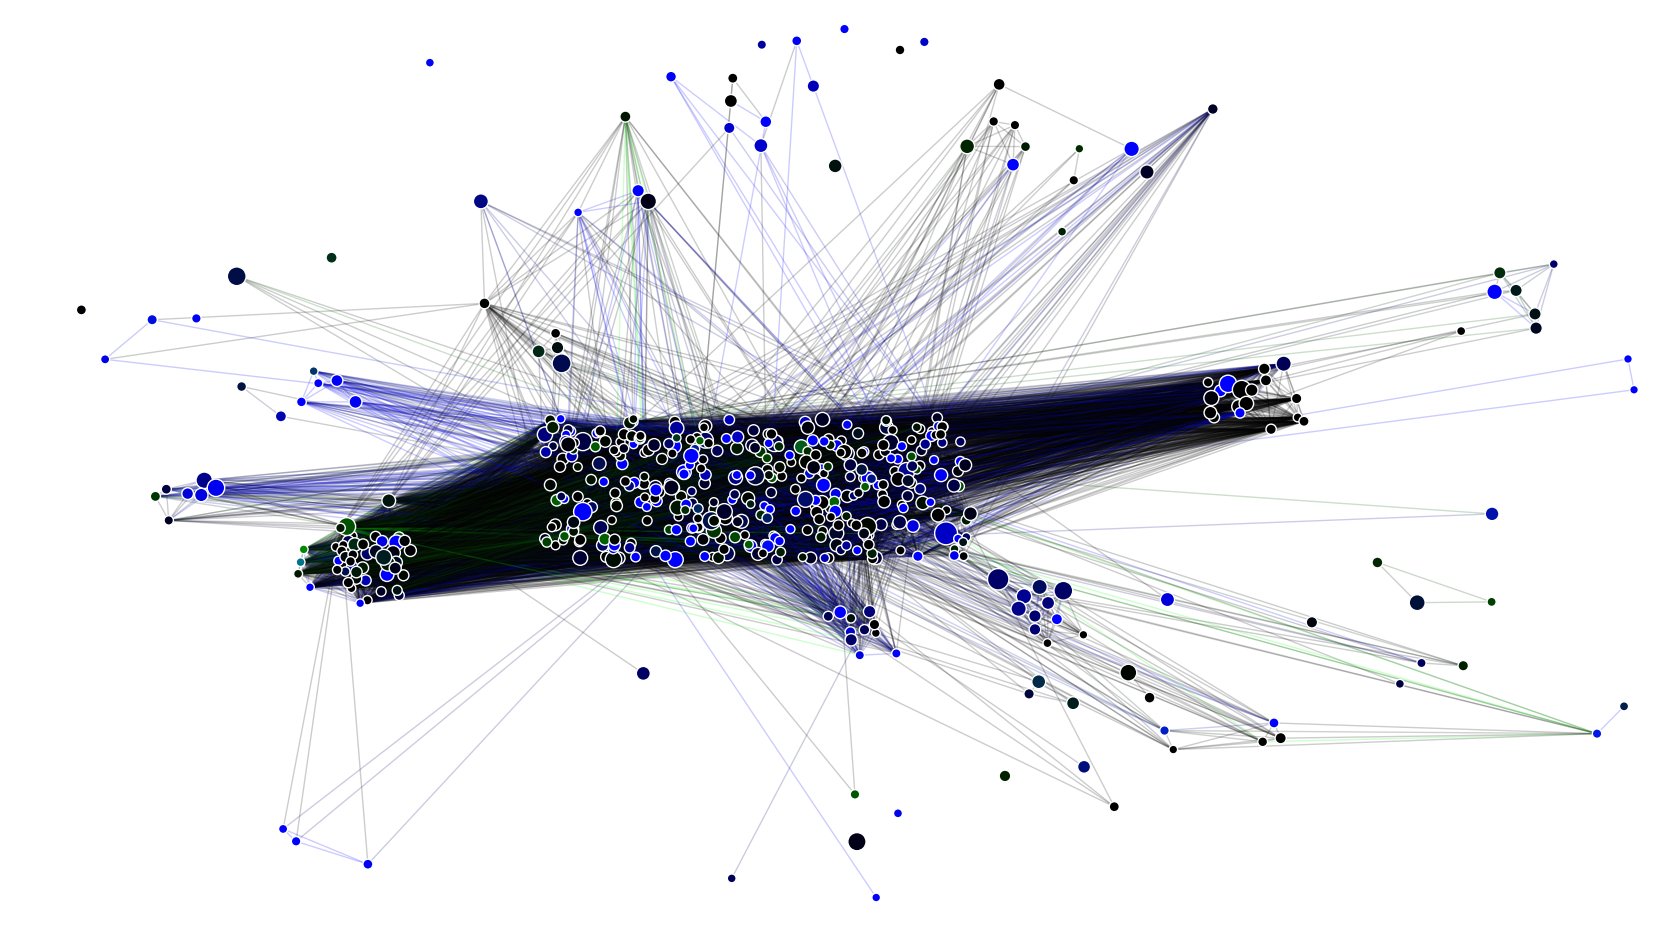

In [51]:
generate_network_graph(nodes, edges)

In [52]:
print ADJ_green

COMPANY                         ELECTRICITE DE FRANCE  \
COMPANY                                                 
ELECTRICITE DE FRANCE                             2.5   
TOKYO ELECTRIC POWER CO                           0.0   
ENEL SPA                                          0.0   
KANSAI ELECTRIC POWER CO                          0.0   
COMISION FEDERAL DE ELEC                          0.0   
HUANENG POWER INTERNATIONAL                       0.0   
ROSENERGOATOM                                     0.0   
TAIWAN POWER CO                                   0.0   
ESKOM                                             0.0   
RAO UES ROSSII                                    0.0   
CHUBU ELECTRIC POWER CO                           0.0   
NATIONAL THERMAL POWER CORP                       0.0   
CALPINE CORP                                      0.0   
HYDRO-QUEBEC                                      0.0   
CHINA YANGTZE POWER CORP (CYP)                    0.0   
TENNESSEE VALLEY AUTH          